In [ ]:
%reset -f

## Construire un modèle

### Sur les notations

Un modèle est une fonction paramétrique, qui prend donc deux argument:
* un paramètre noté `param` ou `params` ou `Θ`
* Une entrée (input). Noté `inp`, `x`, `xy` `X` etc.

Perso:
* Dans un contexte de data j'appelle mon modèle simplement `model`, `model_apply`
* Dans un contexte de calcul scientifique (notamment pour les Pinns), je le note `U_of_Θ_inp` ou  `U_of_Θ_x` ou `U_of_Θ_xy` etc.


Je rajoute des `V` pour les version vectoriées par exemple `U_of_Θ_inpV` (et ce n'est que les `inpV` qui sont vectorisées).


Le paramètre est le premier argument, car le plus souvent on calcule de gradient par rapport au paramètre, et que la fonction `jax.grad` a comme défaut `jax.grad(fn,argnums=0)`

### Définition des `params` d'un modèle

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import matplotlib.pyplot as plt

En Jax il y a plein de façon de créer des modèles. La plus simple était d'utiliser le design `model_init, model_apply`:

In [ ]:
#j'utilise le suffix "fnm" pour "function_maker"
def model_fnm(layer_widths):

    def model_init(rkey):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            rk,rkey=jr.split(rkey)
            params.append(
                {"weight":jr.normal(rk,shape=(n_in, n_out))*jnp.sqrt(2/n_in),
                "bias":jnp.zeros([n_out])})
        return params

    def model_apply(params, inp):
        *hidden, last = params
        for layer in hidden:
            inp = jax.nn.relu(inp @ layer['weight'] + layer['bias'])
        return inp @ last['weight'] + last['bias']

    return model_init,model_apply

model_init,model_apply=model_fnm([2,4,8,1])

In [ ]:
params=model_init(jr.key(0))
for tensor in jax.tree.leaves(params):
    print(tensor.shape)

***A vous:*** Faites un graphique qui illustre cette architecture. As-t-on mis une fonction d'activation finale ?

### Polyvalence

Rappelons que l'opérateur `@` est polyvalent:

In [ ]:
inp=jnp.ones([3])
mat=jnp.ones([3,4])
(inp@mat).shape

In [ ]:
inpV=jnp.ones([7,3])
mat=jnp.ones([3,4])
(inpV@mat).shape

Par conséquent, model_apply est polyvalent:

In [ ]:
model_init,model_apply=model_fnm([2,4,8,5])
params=model_init(jr.key(0))

In [ ]:
inp=jnp.ones([2])
model_apply(params,inp).shape

In [ ]:
inpV=jnp.ones([7,2])
out_predV=model_apply(params,inpV)
out_predV.shape

In [ ]:
model_applyV=vmap(model_apply,in_axes=(None,0))
out_predV_bis=model_applyV(params,inpV)
out_predV_bis.shape

In [ ]:
assert jnp.allclose(out_predV,out_predV_bis)

Mais attention, certain modèles de deep-learning plus complexe n'ont pas cette polyvalence. Dans les librairies comme torch ou tensorflow, on construit uniquement les versions vectorisées des modèles càd qu'on prévoit toujours un indice de batch en premier.

En jax l'habitude est de construire des modèles non-vectorisées, et de leur appliquer `vmap` ensuite. Cela prend tous son sens dans un contexte de calcul scientifique, où l'on est amener aussi à dériver selon les inputs.

### Un entrainement


In [ ]:
def go():
    inp_dim=2
    out_dim=3

    layer_widths=[inp_dim,4,8,out_dim]
    model_init,model_apply=model_fnm(layer_widths)
    params=model_init(jr.key(0))


    #the loss function.
    def loss_fn(params, inpV, outV):
        #must return a scalar
        return jnp.mean((model_apply(params, inpV) - outV) ** 2)

    #learning rate.
    lr = 0.01

    losses=[]
    # the parameter update function.
    def update(params, inp, out,model_apply):
        # Calculate the gradients with `jax.grad`.
        loss,grads = jax.value_and_grad(loss_fn)(params, inp, out)
        # Note that `grads` is a pytree with the same structure as `params`.

        params=jax.tree.map(
            lambda p, g: p - lr * g, params, grads
        )
        return loss,params

    rkey=jr.key(0)
    for _ in range(100):
        rk,rkey=jr.split(rkey)
        inp=jr.normal(rk,shape=(100,inp_dim))
        out=jnp.zeros((100,out_dim))
        loss,params=update(params,inp,out,model_apply)
        losses.append(loss)

    losses=jnp.array(losses)
    return losses

losses=go()

In [ ]:
fig,ax=plt.subplots()
ax.plot(losses)
ax.set_ylabel("loss")
ax.set_xlabel("iteration");

***A vous:*** Quelle fonction a-t-on apprise dans l'entrainement précédent ?


L'optimisation précédente est appelé 'stochastic gradient descent'. Le mot stochastic = aléatoire vient du fait que les inputs sont aléatoires.



Modifiez le programme précédent pour que les inputs soient les mêmes pour tous les steps d'optimisation. Comparez les courbes de loss.



## Problème linéaire 1D



In [ ]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

In [ ]:
def inpV_outV_fn(rkey):
    ...


In [ ]:
inpV,outV=inpV_outV_fn(jr.key(0))
inpV.shape,outV.shape

On a pris soit d'ajouter une dimension avec `[:,None]` pour respecteur le format des données classiques: `(batch_size,dim)`

In [ ]:
plt.scatter(inpV, outV, color='b',marker='.');

***A vous:*** Débugguez le programme suivant (proposé par Gemini). Le bon programme (partiellement caché) est exécuté plus bas.

In [ ]:
def inpV_outV_fn_bug(rkey):
    inputs  = jr.normal(rkey,shape=(NUM_EXAMPLES,))
    noise   = jr.normal(rkey,shape=(NUM_EXAMPLES,))
    outputs = inputs * TRUE_W + TRUE_b + noise
    return inputs[None],outputs[None]

inpV,outV=inpV_outV_fn_bug(jr.key(0))
plt.scatter(inpV, outV, color='b',marker='.');

***A vous:*** Trouvez la meilleurs droite affine de régression

In [ ]:
def go():
    ...


In [ ]:
inpV,outV=inpV_outV_fn(jr.key(0))
fig,ax=plt.subplots()
ax.scatter(inpV, outV, color='b',marker='.')

inpV_regulars=jnp.linspace(inpV.min(),inpV.max(),100)[:,None]
ax.plot(inpV_regulars,model_apply(params_trained,inpV_regulars),color='r');

***A vous:*** Retracez la droite rouge sans utiliser la fonction `model_apply`, mais uniquement à partir des valeurs dans `params_trained`.

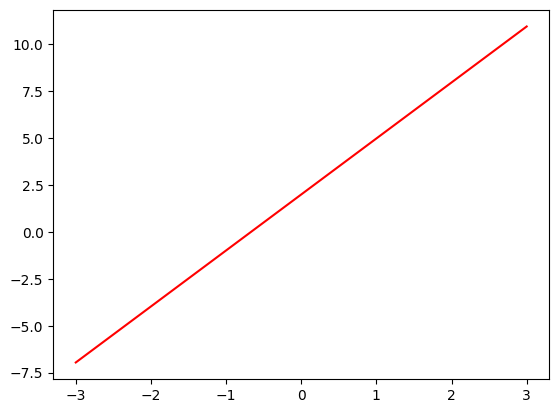

In [ ]:
#--- To keep following outputs, do not run this cell! ---